<a href="https://colab.research.google.com/github/hasdasda/BTLcoLan/blob/main/ThuvoiGao_Feng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


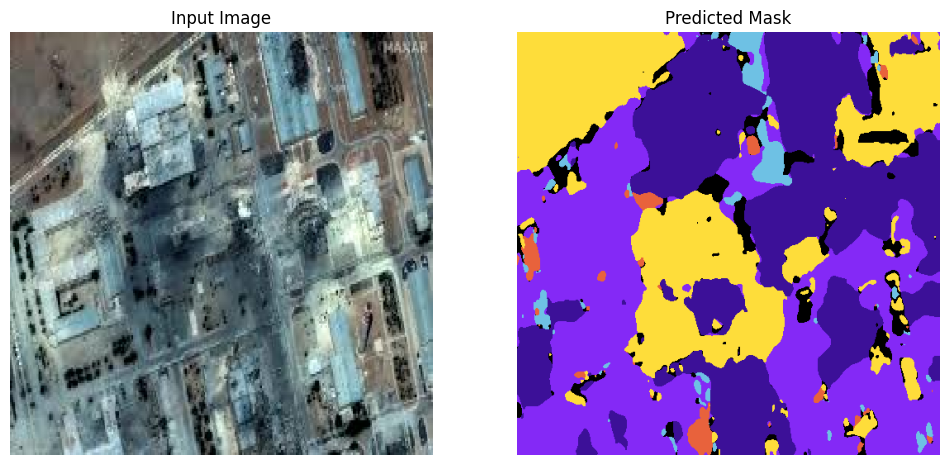

Predicted mask saved as 'predicted_mask.png'


In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image


# Kiến trúc U-Net CHÍNH XÁC từ notebook huấn luyện
def build_exact_unet(input_shape=(512, 512, 3), num_classes=7):
    input_layer = Input(shape=input_shape)

    # Encoder
    encoder = Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(input_layer)
    encoder = Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(encoder)
    block1_output = encoder
    encoder = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoder)

    encoder = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(encoder)
    encoder = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(encoder)
    block2_output = encoder
    encoder = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoder)

    encoder = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(encoder)
    encoder = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(encoder)
    block3_output = encoder
    encoder = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoder)

    encoder = Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(encoder)
    encoder = Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(encoder)
    block4_output = encoder
    encoder_output = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoder)

    # Bottleneck (CHÍNH XÁC như notebook)
    bottleneck = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding='same')(encoder_output)
    bottleneck = Conv2D(filters=1024, kernel_size=(3, 3), activation="relu", padding='same')(bottleneck)
    bottleneck_output = UpSampling2D(size=(2, 2))(bottleneck)

    # Decoder
    decoder = Conv2D(filters=1024, kernel_size=(3, 3), activation="relu", padding='same')(bottleneck_output)
    decoder = concatenate([block4_output, decoder])
    decoder = Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(decoder)

    decoder = UpSampling2D(size=(2, 2))(decoder)
    decoder = Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(decoder)
    decoder = concatenate([block3_output, decoder])
    decoder = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(decoder)

    decoder = UpSampling2D(size=(2, 2))(decoder)
    decoder = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(decoder)
    decoder = concatenate([block2_output, decoder])
    decoder = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(decoder)

    decoder = UpSampling2D(size=(2, 2))(decoder)
    decoder = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(decoder)
    decoder = concatenate([block1_output, decoder])
    decoder = Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(decoder)
    decoder = Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(decoder)

    # Output layer
    outputs = Conv2D(filters=num_classes, kernel_size=(1, 1), activation="softmax")(decoder)

    model = Model(inputs=input_layer, outputs=outputs)
    return model


# Load mô hình với kiến trúc chính xác
model = build_exact_unet()
model.load_weights('best_model.weights.h5')


# Hàm tiền xử lý ảnh
def preprocess_image(image_path, target_size=(512, 512)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img


# Hàm dự đoán và hiển thị
def predict_and_visualize(model, image_path, class_colors):
    img = preprocess_image(image_path)
    pred = model.predict(img)[0]
    pred_class = np.argmax(pred, axis=-1)

    pred_rgb = np.zeros((*pred_class.shape, 3), dtype=np.uint8)
    for class_idx, color in enumerate(class_colors):
        pred_rgb[pred_class == class_idx] = color

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_rgb)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

    return pred_rgb


# Màu sắc cho các lớp
CLASS_COLORS = [
    [0, 0, 0],  # Unlabeled
    [60, 16, 152],  # Building
    [132, 41, 246],  # Land
    [110, 193, 228],  # Road
    [254, 221, 58],  # Vegetation
    [226, 169, 41],  # Water
    [232, 98, 60]  # Object
]

# Sử dụng mô hình
if __name__ == "__main__":
    image_path = 'images.jpg'  # Thay bằng ảnh của bạn
    pred_mask = predict_and_visualize(model, image_path, CLASS_COLORS)

    # Lưu kết quả
    pred_mask_img = Image.fromarray(pred_mask)
    pred_mask_img.save('predicted_mask.png')
    print("Predicted mask saved as 'predicted_mask.png'")

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
!pip install -q kaggle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Tạo thư mục .kaggle
!mkdir -p ~/.kaggle

# Dán file kaggle.json của bạn vào đây (được tải từ tài khoản Kaggle)
!echo '{"username":"hieupham2076","key":"dfdfc48a93015fe63b5c614898afd042"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Tạo thư mục đích nếu chưa tồn tại
# !mkdir -p "/content/drive/MyDrive/CloudGAN-main/kaggle_output"

# Tải xuống output kernel
!kaggle kernels output iakhtar0/land-cover-segmentation-waqas-hamza-project -p "/content/drive/MyDrive/CloudGAN-main/kaggle_output"

model.png: Skipping, found more recently modified local copy (use --force to force download)
Output file downloaded to /content/drive/MyDrive/CloudGAN-main/kaggle_output/my_dataset_folder/my_dataset.tfrecord
Output file downloaded to /content/drive/MyDrive/CloudGAN-main/kaggle_output/saved_models/best_model.weights.h5
Kernel log downloaded to /content/drive/MyDrive/CloudGAN-main/kaggle_output/land-cover-segmentation-waqas-hamza-project.log 


In [14]:
!pwd

/content
